In [1]:
# libraries
#%matplotlib notebook
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [2]:
# Write a function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)


# train markov model to get transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

#### Data extraction

In [188]:
df = pd.read_csv(r'C:\Users\judit.gyorfi\OneDrive - Irdeto B.V\data for thesis\084f43ba-85ca-4dd0-a2d2-5595951d6070.csv')

In [189]:
df

,datevalue,LicenseCount,sessionuserid
0,2021-04-27 02:00:00.000,10,LXM.8448:8448400841155745
1,2021-04-27 19:00:00.000,1,LXM.8448:8448200232369719
2,2021-04-27 02:00:00.000,6,CHARTER.8245:8245100361014273
3,2021-04-27 19:00:00.000,6,CAR.202:355781505
4,2021-04-27 03:00:00.000,1,CHARTER.8245:8245100614052781
...,...,...,...
9639215,2021-04-27 03:00:00.000,1,NER.202:912788102
9639216,2021-04-27 20:00:00.000,1,CVG.003:434183701
9639217,2021-04-27 21:00:00.000,1,CHARTER.8352:8352300600124524
9639218,2021-04-27 03:00:00.000,1,NYC.8150:8150110017667526


In [190]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9639220 entries, 0 to 9639219
Data columns (total 3 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   datevalue      object
 1   LicenseCount   int64 
 2   sessionuserid  object
dtypes: int64(1), object(2)
memory usage: 220.6+ MB
None


In [191]:
df['datevalue'] = pd.to_datetime(df['datevalue'])

#### Feature engineering

In [192]:
df['hours'] = df['datevalue'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df

,datevalue,LicenseCount,sessionuserid,hours,daylight
0,2021-04-27 02:00:00,10,LXM.8448:8448400841155745,2,0
1,2021-04-27 19:00:00,1,LXM.8448:8448200232369719,19,1
2,2021-04-27 02:00:00,6,CHARTER.8245:8245100361014273,2,0
3,2021-04-27 19:00:00,6,CAR.202:355781505,19,1
4,2021-04-27 03:00:00,1,CHARTER.8245:8245100614052781,3,0
...,...,...,...,...,...
9639215,2021-04-27 03:00:00,1,NER.202:912788102,3,0
9639216,2021-04-27 20:00:00,1,CVG.003:434183701,20,1
9639217,2021-04-27 21:00:00,1,CHARTER.8352:8352300600124524,21,1
9639218,2021-04-27 03:00:00,1,NYC.8150:8150110017667526,3,0


In [193]:
df['DayOfTheWeek'] = df['datevalue'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [194]:
# time with int to plot easily
df['time_epoch'] = (df['datevalue'].astype(np.int64)/100000000000).astype(np.int64)

<ipython-input-195-927966d5255a>:16: RuntimeWarning: invalid value encountered in true_divide
  ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
<ipython-input-195-927966d5255a>:17: RuntimeWarning: invalid value encountered in true_divide
  ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')


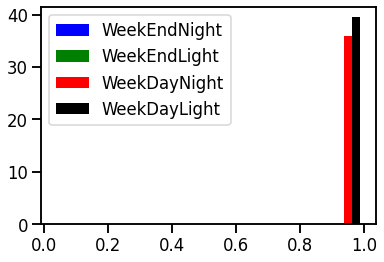

In [195]:
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'LicenseCount']
b = df.loc[df['categories'] == 1, 'LicenseCount']
c = df.loc[df['categories'] == 2, 'LicenseCount']
d = df.loc[df['categories'] == 3, 'LicenseCount']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/4

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

In [196]:
df

,datevalue,LicenseCount,sessionuserid,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories
0,2021-04-27 02:00:00,10,LXM.8448:8448400841155745,2,0,1,1,16194888,2
1,2021-04-27 19:00:00,1,LXM.8448:8448200232369719,19,1,1,1,16195500,3
2,2021-04-27 02:00:00,6,CHARTER.8245:8245100361014273,2,0,1,1,16194888,2
3,2021-04-27 19:00:00,6,CAR.202:355781505,19,1,1,1,16195500,3
4,2021-04-27 03:00:00,1,CHARTER.8245:8245100614052781,3,0,1,1,16194924,2
...,...,...,...,...,...,...,...,...,...
9639215,2021-04-27 03:00:00,1,NER.202:912788102,3,0,1,1,16194924,2
9639216,2021-04-27 20:00:00,1,CVG.003:434183701,20,1,1,1,16195536,3
9639217,2021-04-27 21:00:00,1,CHARTER.8352:8352300600124524,21,1,1,1,16195572,3
9639218,2021-04-27 03:00:00,1,NYC.8150:8150110017667526,3,0,1,1,16194924,2


In [197]:
timeseries = df.copy()

In [157]:
df['datevalue'].min()

Timestamp('2021-04-27 00:00:00')

In [158]:
df['datevalue'].max()

Timestamp('2021-04-27 23:00:00')

In [241]:
df.insert(0, 'New_ID', range(880, 880 + len(df)))
df

,New_ID,datevalue,LicenseCount,sessionuserid,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories
0,880,2021-04-27 02:00:00,10,LXM.8448:8448400841155745,2,0,1,1,16194888,2
1,881,2021-04-27 19:00:00,1,LXM.8448:8448200232369719,19,1,1,1,16195500,3
2,882,2021-04-27 02:00:00,6,CHARTER.8245:8245100361014273,2,0,1,1,16194888,2
3,883,2021-04-27 19:00:00,6,CAR.202:355781505,19,1,1,1,16195500,3
4,884,2021-04-27 03:00:00,1,CHARTER.8245:8245100614052781,3,0,1,1,16194924,2
...,...,...,...,...,...,...,...,...,...,...
9639215,9640095,2021-04-27 03:00:00,1,NER.202:912788102,3,0,1,1,16194924,2
9639216,9640096,2021-04-27 20:00:00,1,CVG.003:434183701,20,1,1,1,16195536,3
9639217,9640097,2021-04-27 21:00:00,1,CHARTER.8352:8352300600124524,21,1,1,1,16195572,3
9639218,9640098,2021-04-27 03:00:00,1,NYC.8150:8150110017667526,3,0,1,1,16194924,2


In [160]:
y = x[:30]
y = y.reset_index()
y = y['sessionuserid'].tolist()

In [161]:
y

['CHARTER.8352:8352303310097196',
 'CAR.202:270184201',
 'CHARTER.8783:8783600110006387',
 'CHARTER.8313:8313300310158653',
 'LXM.8448:8448300640682263',
 'LXM.8448:8448300743185586',
 'PLM.8448:8448410770037343',
 'LXM.8448:8448300324371373',
 'CHARTER.8354:8354100015254744',
 'PLM.8448:8448410720230121',
 'PLM.8448:8448410770024242',
 'CHARTER.8781:8781141310228028',
 'BHN.003:631548901',
 'CHARTER.8245:8245125180812706',
 'CHARTER.8353:8353700220450630',
 'CMH.002:745654701',
 'BHN.003:631408601',
 'NYC.8150:8150110026219343',
 'BHN.003:420097501',
 'NTX.8260:8260130323913072',
 'CAR.202:229261517',
 'LXM.8448:8448400214390341',
 'CVG.003:804468905',
 'BHN.003:382001301',
 'CHARTER.8313:8313300220422736',
 'INS.002:746402101',
 'CHARTER.8245:8245100614304208',
 'CAR.202:045787604',
 'CTX.8260:8260161480165768',
 'LXM.8448:8448200189248627']

In [162]:
df = df[df['sessionuserid'].isin(y)]
df

,datevalue,LicenseCount,sessionuserid,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories
3175,2021-04-27 10:00:00,20,INS.002:746402101,10,1,1,1,16195176,3
5423,2021-04-27 19:00:00,19,PLM.8448:8448410770037343,19,1,1,1,16195500,3
13390,2021-04-27 14:00:00,43,PLM.8448:8448410720230121,14,1,1,1,16195320,3
22902,2021-04-27 12:00:00,4,LXM.8448:8448300324371373,12,1,1,1,16195248,3
25702,2021-04-27 06:00:00,4,CHARTER.8352:8352303310097196,6,0,1,1,16195032,2
...,...,...,...,...,...,...,...,...,...
9475492,2021-04-27 04:00:00,7,PLM.8448:8448410770024242,4,0,1,1,16194960,2
9494215,2021-04-27 16:00:00,6,CHARTER.8783:8783600110006387,16,1,1,1,16195392,3
9550850,2021-04-27 20:00:00,4,LXM.8448:8448300743185586,20,1,1,1,16195536,3
9597070,2021-04-27 12:00:00,2,CHARTER.8245:8245125180812706,12,1,1,1,16195248,3


#### Time series analysis

###### We consider daylight between 7am and 22pm.

In [200]:
time = timeseries.groupby('daylight')['datevalue'].count().sort_values(ascending=False)
time = pd.DataFrame(time)
time

,datevalue
daylight,
1,5213115
0,4426105


###### Do really so many people consume content between midnight and 4am? Let's clarify the timezone.

In [240]:
time3 = timeseries.groupby('hours')['LicenseCount'].count()
time3 = pd.DataFrame(time3)
time3 = time3.reset_index()
time3['mean'] = timeseries.groupby('hours')['LicenseCount'].mean()
time3

,hours,LicenseCount,mean
0,0,789639,3.018407
1,1,755623,3.186232
2,2,750592,2.958685
3,3,568665,2.824396
4,4,384989,2.776801
5,5,320084,2.584053
6,6,214894,2.488706
7,7,160647,2.398464
8,8,166637,2.370848
9,9,189127,2.305710


No handles with labels found to put in legend.


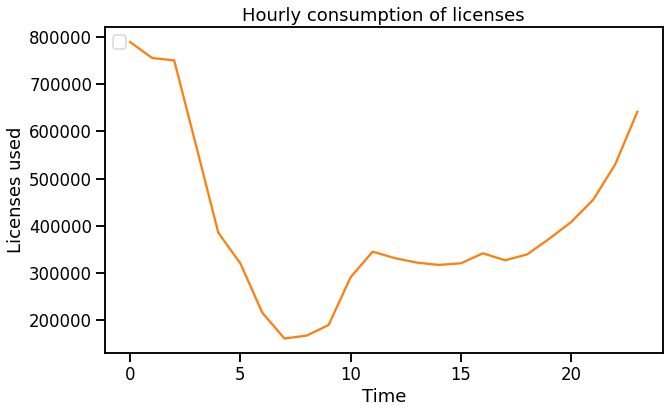

In [230]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(time3.hours, time3.LicenseCount, color='tab:orange')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Licenses used')
ax.set_title('Hourly consumption of licenses')

ax.legend(loc='upper left');

##### Ideas for further exploration: weekday vs weekend, 

In [163]:
data = df[['sessionuserid','LicenseCount', 'hours','daylight','DayOfTheWeek','WeekDay','datevalue']]
data

,sessionuserid,LicenseCount,hours,daylight,DayOfTheWeek,WeekDay,datevalue
3175,INS.002:746402101,20,10,1,1,1,2021-04-27 10:00:00
5423,PLM.8448:8448410770037343,19,19,1,1,1,2021-04-27 19:00:00
13390,PLM.8448:8448410720230121,43,14,1,1,1,2021-04-27 14:00:00
22902,LXM.8448:8448300324371373,4,12,1,1,1,2021-04-27 12:00:00
25702,CHARTER.8352:8352303310097196,4,6,0,1,1,2021-04-27 06:00:00
...,...,...,...,...,...,...,...
9475492,PLM.8448:8448410770024242,7,4,0,1,1,2021-04-27 04:00:00
9494215,CHARTER.8783:8783600110006387,6,16,1,1,1,2021-04-27 16:00:00
9550850,LXM.8448:8448300743185586,4,20,1,1,1,2021-04-27 20:00:00
9597070,CHARTER.8245:8245125180812706,2,12,1,1,1,2021-04-27 12:00:00


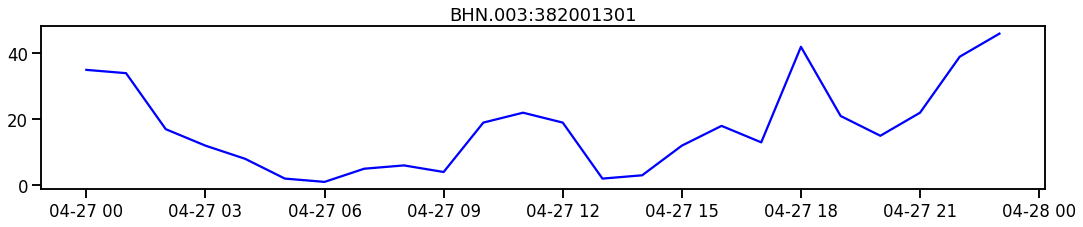

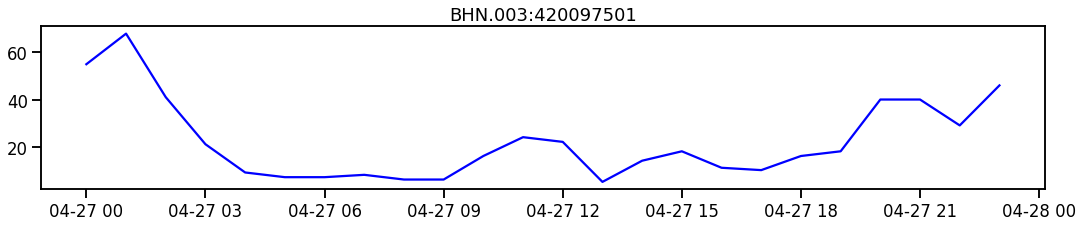

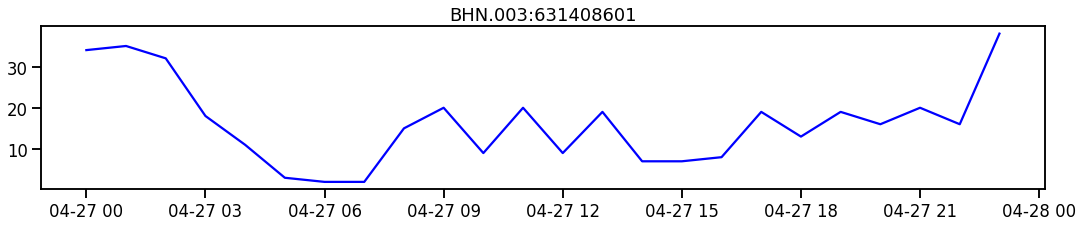

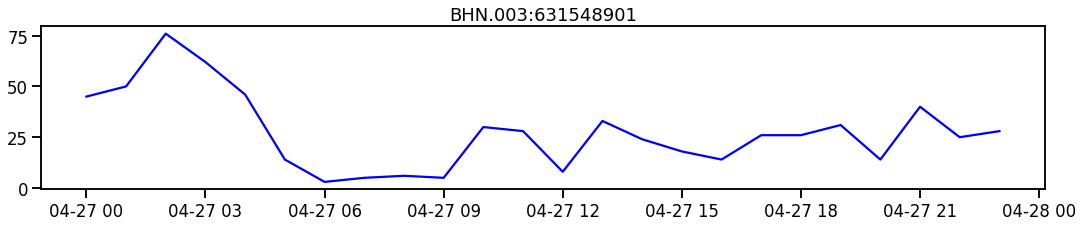

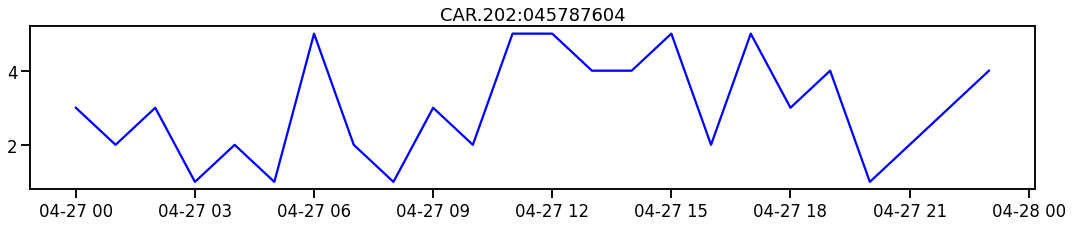

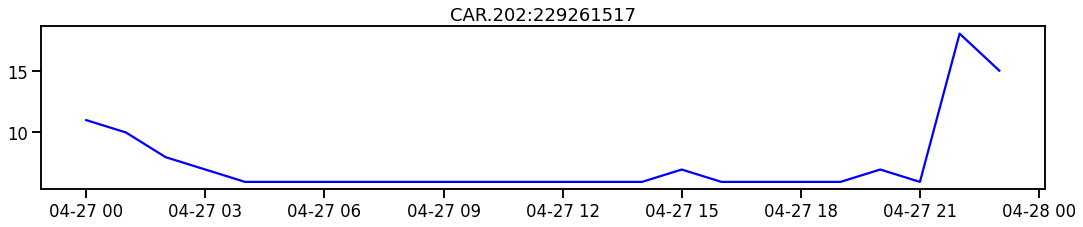

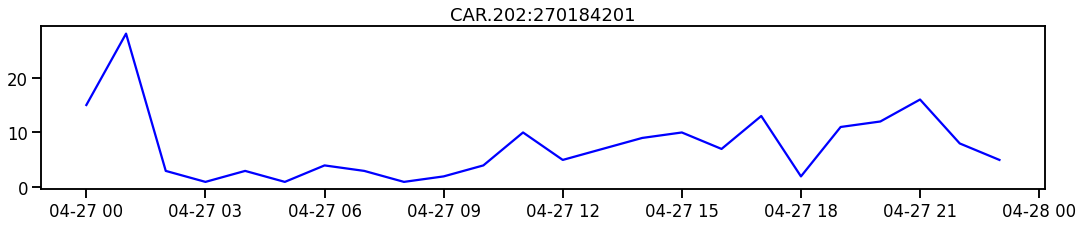

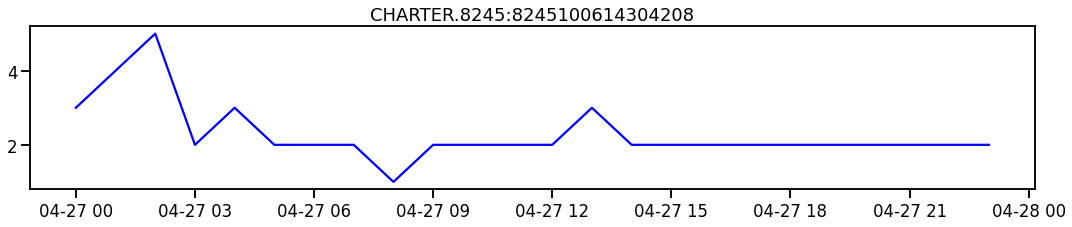

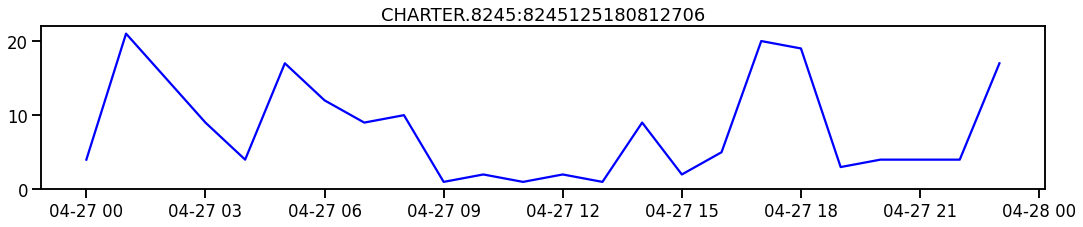

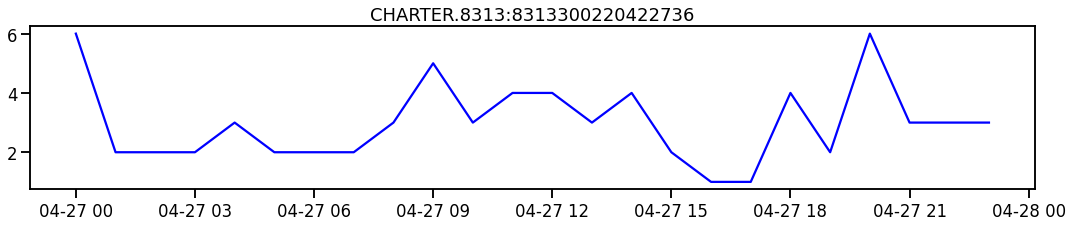

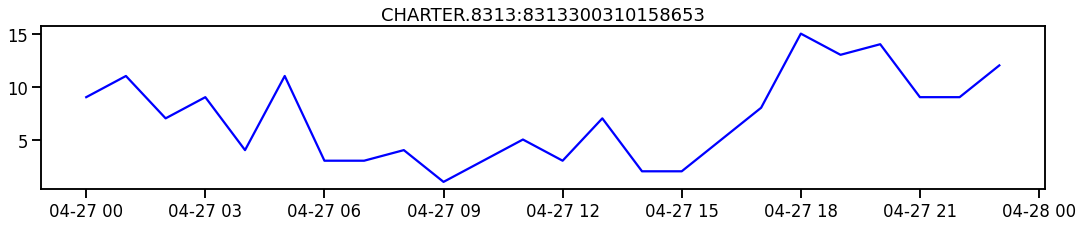

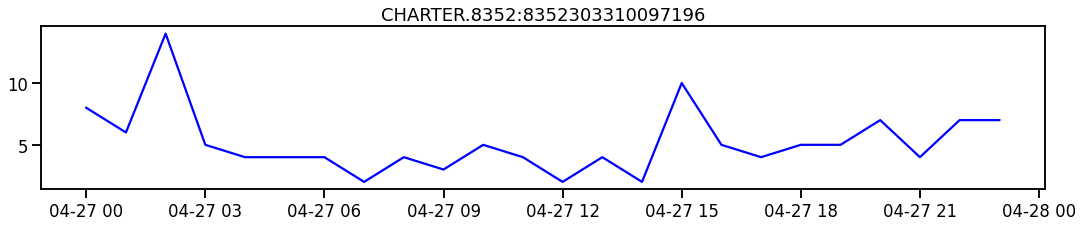

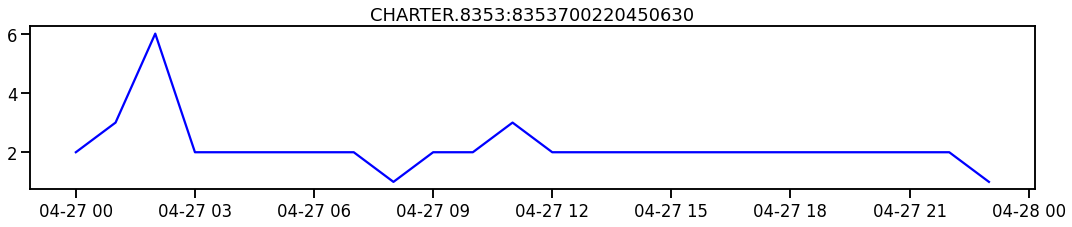

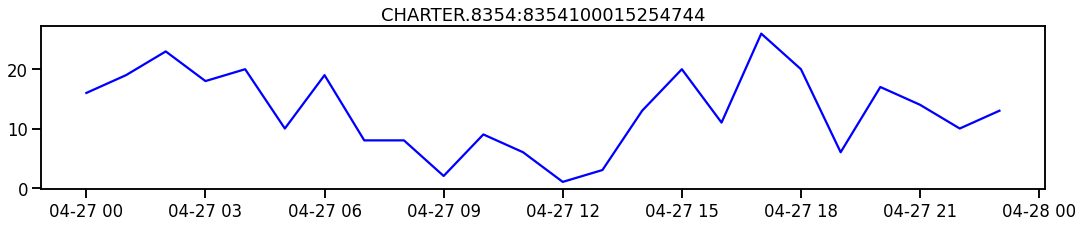

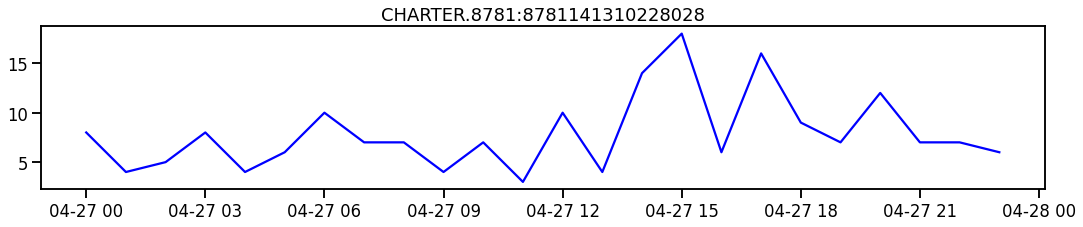

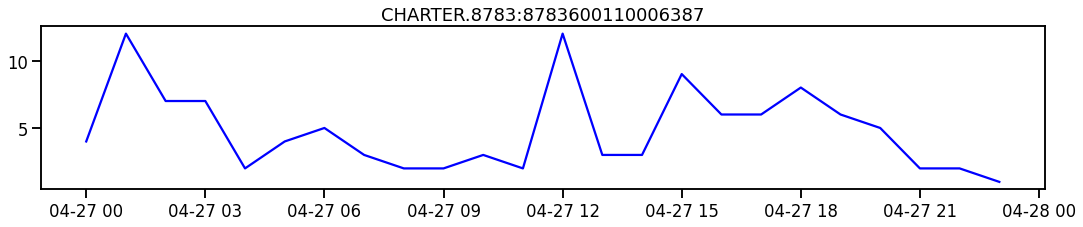

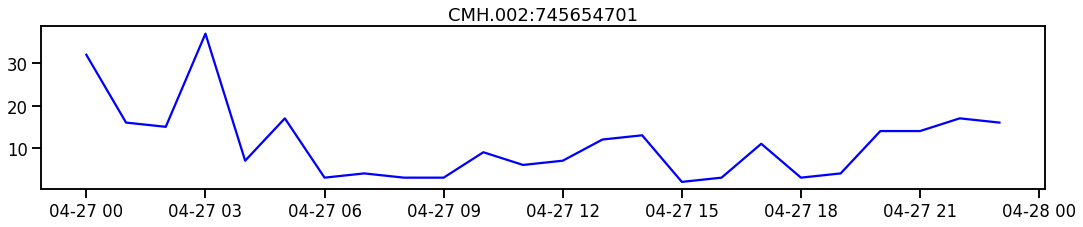

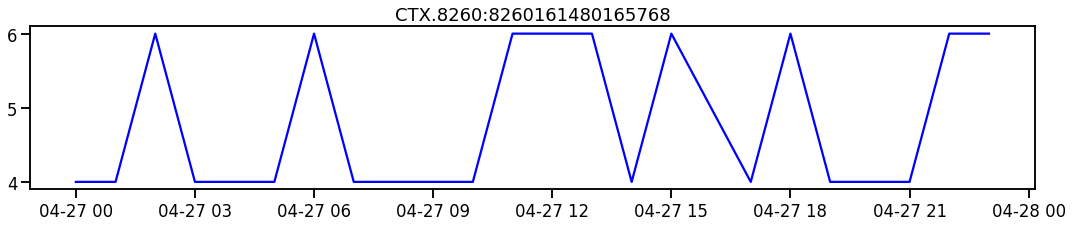

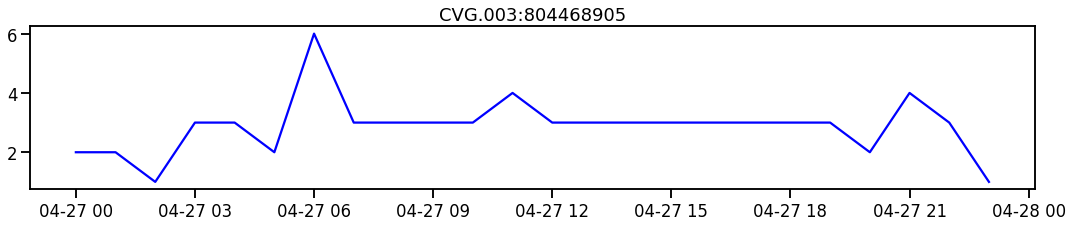

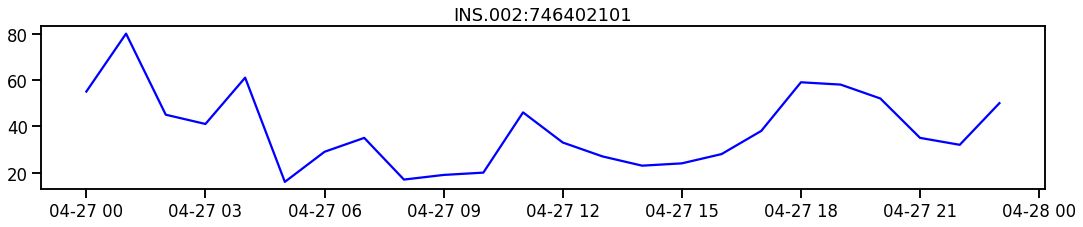

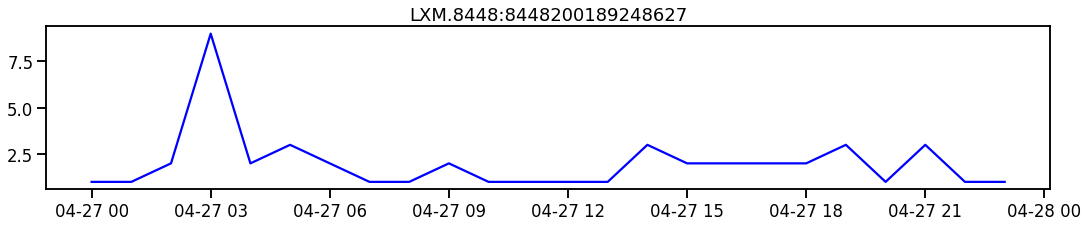

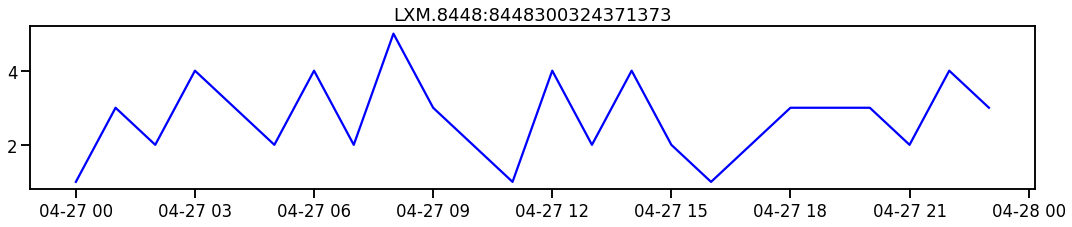

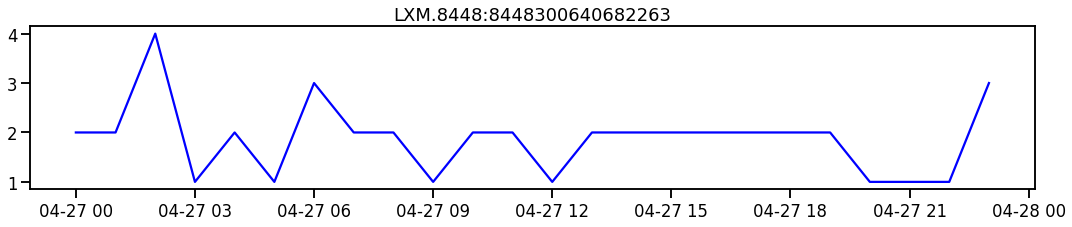

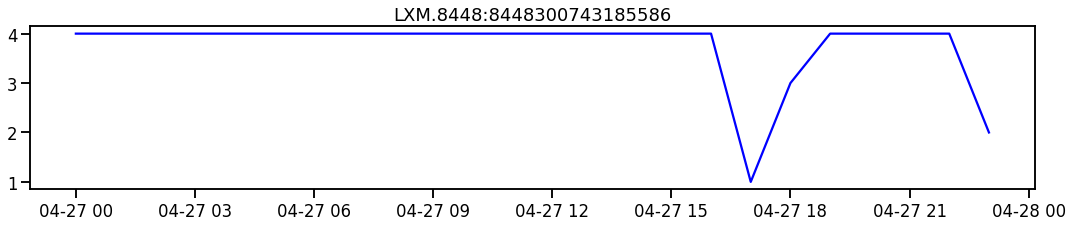

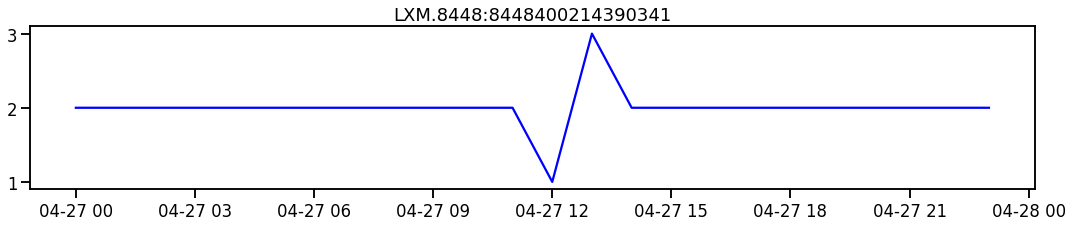

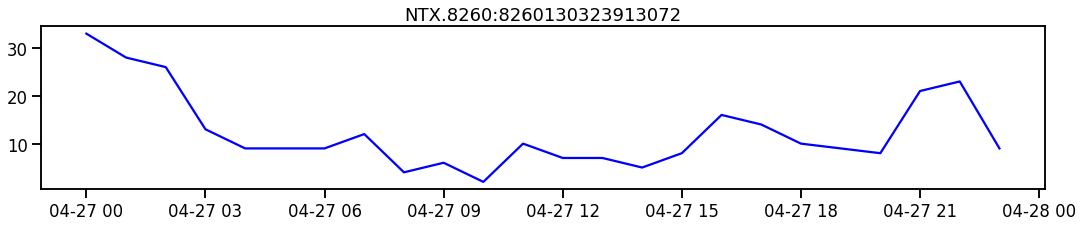

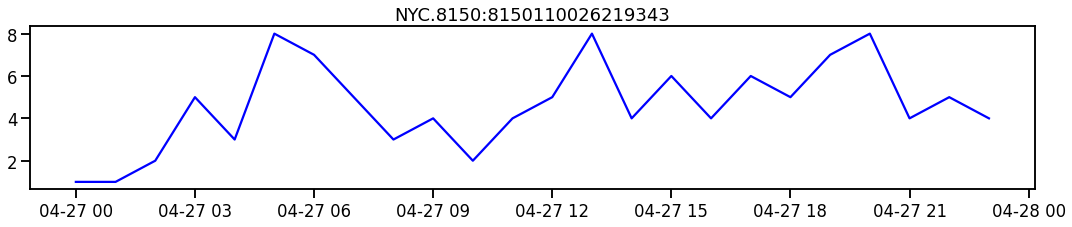

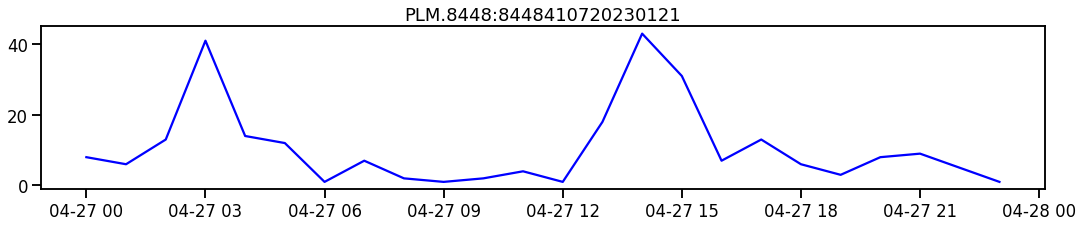

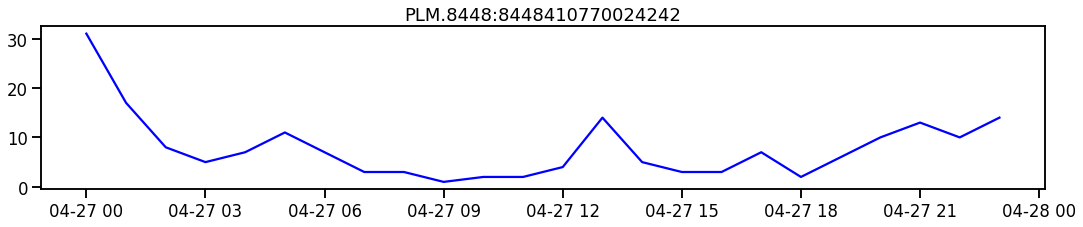

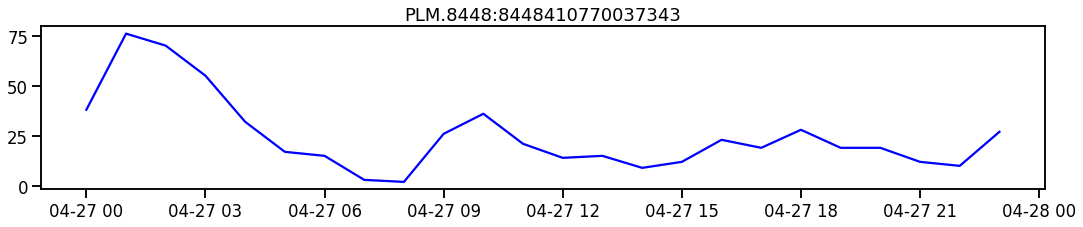

In [166]:
names=data.columns
for name in names:
    sns.set_context('talk')
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(data[name], color='blue')
    _ = plt.title(name)
    plt.show()

In [164]:
# Take useful feature and standardize them
data = data.pivot(index='datevalue', columns='sessionuserid', values='LicenseCount')
data

sessionuserid,BHN.003:382001301,BHN.003:420097501,BHN.003:631408601,BHN.003:631548901,CAR.202:045787604,CAR.202:229261517,CAR.202:270184201,CHARTER.8245:8245100614304208,CHARTER.8245:8245125180812706,CHARTER.8313:8313300220422736,...,LXM.8448:8448200189248627,LXM.8448:8448300324371373,LXM.8448:8448300640682263,LXM.8448:8448300743185586,LXM.8448:8448400214390341,NTX.8260:8260130323913072,NYC.8150:8150110026219343,PLM.8448:8448410720230121,PLM.8448:8448410770024242,PLM.8448:8448410770037343
datevalue,,,,,,,,,,,,,,,,,,,,,
2021-04-27 00:00:00,35,55,34,45,3,11,15,3,4,6,...,1,1,2,4,2,33,1,8,31,38
2021-04-27 01:00:00,34,68,35,50,2,10,28,4,21,2,...,1,3,2,4,2,28,1,6,17,76
2021-04-27 02:00:00,17,41,32,76,3,8,3,5,15,2,...,2,2,4,4,2,26,2,13,8,70
2021-04-27 03:00:00,12,21,18,62,1,7,1,2,9,2,...,9,4,1,4,2,13,5,41,5,55
2021-04-27 04:00:00,8,9,11,46,2,6,3,3,4,3,...,2,3,2,4,2,9,3,14,7,32
2021-04-27 05:00:00,2,7,3,14,1,6,1,2,17,2,...,3,2,1,4,2,9,8,12,11,17
2021-04-27 06:00:00,1,7,2,3,5,6,4,2,12,2,...,2,4,3,4,2,9,7,1,7,15
2021-04-27 07:00:00,5,8,2,5,2,6,3,2,9,2,...,1,2,2,4,2,12,5,7,3,3
2021-04-27 08:00:00,6,6,15,6,1,6,1,1,10,3,...,1,5,2,4,2,4,3,2,3,2


In [165]:
df = data.copy()

In [167]:
# Take useful feature and standardize them
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

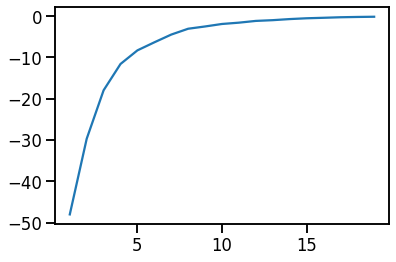

In [168]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [169]:
data[0]

0     1.930582
1     2.468443
2     2.293727
3     0.347298
4    -0.042024
5    -0.629407
6    -1.087155
7    -0.973449
8    -1.193498
9    -1.046920
10   -0.502097
11   -0.211460
12   -0.871065
13   -0.426492
14   -0.838246
15   -0.533148
16   -0.416795
17    0.009403
18    0.176005
19   -0.144142
20    0.109283
21    0.201364
22    0.305450
23    1.074345
Name: 0, dtype: float64

In [170]:
df['cluster'] = kmeans[4].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

0    11
2     6
3     4
1     2
4     1
Name: cluster, dtype: int64

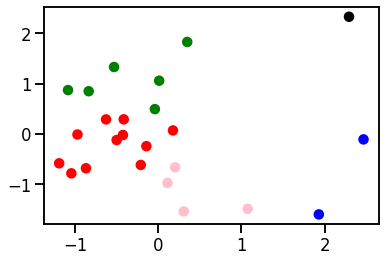

In [171]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
#ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
ax.scatter(data[0], data[1], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [183]:
outliers_fraction = 0.2
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[4])
# number of observations that equate to the 13% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest 13% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

In [184]:
c = (distance >= threshold).astype(int)
c

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     1
8     1
9     1
10    0
11    0
12    1
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
dtype: int32

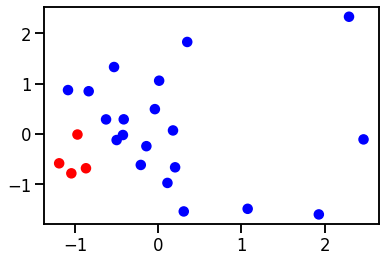

In [185]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(data[0], data[1], c=c.apply(lambda x: colors[x]))
plt.show()